In [1]:
import torch
import math
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from numba import njit, cuda
from torch import nn
import cython

In [9]:
%load_ext cython
#at5854@nyu.edu

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [34]:
@njit
def fix_interface_numba_cpu(grid, seg_indices, alphas, k_interface, c_dt_dx2):
    """
    CPU version of the interface update using Numba.
    Args:
        grid (np.ndarray): 1D array of grid values.
        seg_indices (np.ndarray): Interface indices (last index of left segment).
        alphas (np.ndarray): Conductivities. Length = n_interfaces+1.
        k_interface (np.ndarray): Computed interface conductivities.
        c_dt_dx2 (float): Precomputed factor.
    """
    # Constructed under assistant of CahtGPT
    for i in range(seg_indices.shape[0]):
        idx = seg_indices[i]
        i0 = grid[idx - 1]
        i1 = grid[idx]
        i2 = grid[idx + 1]
        i3 = grid[idx + 2]
        change1 = c_dt_dx2 * (k_interface[i] * (i2 - i1) + alphas[i] * (i0 - i1))
        change2 = c_dt_dx2 * (alphas[i+1] * (i3 - i2) + alphas[i] * (i1 - i2))
        grid[idx] = i1 + change1
        grid[idx+1] = i2 + change2
    return grid

@cuda.jit
def fix_interface_numba_gpu(grid, seg_indices, alphas, k_interface, c_dt_dx2):
    """
    GPU version of the interface update using Numba CUDA.
    This kernel is launched with 1D grid.
    """
    # Constructed under assistant of CahtGPT
    i = cuda.grid(1)
    if i < seg_indices.shape[0]:
        idx = seg_indices[i]
        # Direct indexing on device arrays
        i0 = grid[idx - 1]
        i1 = grid[idx]
        i2 = grid[idx + 1]
        i3 = grid[idx + 2]
        change1 = c_dt_dx2 * (k_interface[i] * (i2 - i1) + alphas[i] * (i0 - i1))
        change2 = c_dt_dx2 * (alphas[i+1] * (i3 - i2) + alphas[i] * (i1 - i2))
        grid[idx] = i1 + change1
        grid[idx+1] = i2 + change2
        
class BC_1D:
    def __init__(self, left, right):
        """
        Args:
            left, right: (alpha, beta, f(t))
        """
        self.left_alpha, self.left_beta, self.left_func = left
        self.right_alpha, self.right_beta, self.right_func = right
        
    def apply(self, grid, dx, cur_time):
        gamma_left = self.left_beta / dx
        gamma_right = self.right_beta / dx
        
        # Left boundary
        grid[0] = (self.left_func(cur_time) - gamma_left * grid[1]) / (self.left_alpha - gamma_left)
 
        # Right boundary (fixed typo)
        grid[-1] = (self.right_func(cur_time) + gamma_right * grid[-2]) / (self.right_alpha + gamma_right)
        
class SegConduct:
    def __init__(self, alphas, segs=[]):
        """
        Args:
            alphas (list[float]): a list of conductivities
            segs (list[float]): boundary of different conductivities
        """
        self.alphas = alphas
        self.segs = segs
        self.conduct_map = None
    
    def sanity_check(self, simu):
        # Check the validility of input conditions
        
        # Check if each segement can be assigned with a value or not
        assert len(self.alphas) == len(self.segs) + 1, 'Number of conductivities does not match with number of segment bars.'
        
        # Check if seg bars are in legal order or not
        jud = True
        if len(self.segs) > 1:
            for i in range(len(self.segs)-1):
                if self.segs[i] >= self.segs[i+1]:
                    jud = False
                    break
        assert jud, 'Value inside segment bars is not strictly monotonically increasing.'
        
        # Check if the seg bar range is still within the simulation grid or not
        assert self.segs[-1] < simu.L - simu.dx and self.segs[0] > 0, 'Position of segment bars is out of simulation bound or too close to the boundary.'
        
        simu.if_seg = True
    
    def make_seg_index_and_calc_k_interface(self, simu):
        # Location of the boundary index is the last index of the left segment
        self.seg_index = []
        self.k_interface = []
        append1 = self.seg_index.append
        append2 = self.k_interface.append
        for i in range(len(self.segs)):
            append1(math.floor(self.segs[i] / simu.dx))
            append2( 2 * self.alphas[i] * self.alphas[i+1] / (self.alphas[i] + self.alphas[i+1]))
  
    def make_conduct_map(self, simu):
        self.conduct_map = torch.zeros(simu.xstep, requires_grad=False)
        # Assigning values
        start = 0
        for i in range(len(self.seg_index)):
            end = self.seg_index[i] + 1
            self.conduct_map[start:end] = self.alphas[i]
            start = end
        self.conduct_map[start:-1] = self.alphas[-1]
        # print(simu.device)
        self.conduct_map = self.conduct_map.to(simu.device)
        # print(self.conduct_map.device)
                     
        
class Heat1dSimu:
    def __init__(self, L, xstep, total_time, tstep, bc, ic, c, plot_step, Q=0, device='cpu', do_progress_bar=True):
        """
        Args:
            L (float): Physical length of the 1D domain.
            xstep (int): Number of *interior* points (excluding boundaries).
            total_time (float): End time for the simulation.
            tstep (int): Number of time steps to take.
            bc (BC_1D or float): Boundary condition.
            ic (callable): Function for initial condition.
            c (float): Diffusion coefficient.
            plot_step (int): How often (in steps) to plot the solution.
            device (str): 'cpu' or 'cuda', which device to use for Tensor operations.
        """
        self.L = L
        self.xstep = xstep
        self.total_time = total_time
        self.tstep = tstep
        self.bc = bc
        self.ic = ic
        self.c = c
        self.cur_time = 0.0
        self.plot_step = plot_step
        self.if_seg = False
        self.do_progress_bar = not do_progress_bar
        self.Q = self.make_heat_source_func(Q)
        # Check device
        if torch.cuda.is_available():
            self.device = device
            print('Your simulation will be performed based on CUDA.')
        else:
            self.device = 'cpu'
            print('Your simulation will be performed based on CPU.')
        self.grid_pos = torch.linspace(0, self.L, steps=self.xstep).to(self.device)
        
        
        # Discretization
        self.dx = L / (xstep + 0)
        self.dt = total_time / tstep
        if isinstance(self.c, SegConduct): # If it is a SegConduct object, conductivity will be applied during update
            mul = 1
            if len(self.c.alphas) > 1:
                self.c.sanity_check(self) # Check if the configure is fine
                self.c.make_seg_index_and_calc_k_interface(self) # Initializing position of interface
                self.c.make_conduct_map(self) # Create a map of conductivity
                factor = max(self.c.alphas) * self.total_time / self.tstep /(self.L / (self.xstep + 1))**2
            else:
                self.c = self.c.alphas[0]
                mul = self.c
                factor = mul * self.total_time / self.tstep /(self.L / (self.xstep + 1))**2
        else:
            mul = c
            factor = mul * self.total_time / self.tstep /(self.L / (self.xstep + 1))**2
        print(factor)   
        assert factor <= 0.5, f'Inappropriate dx and dt value. Your factor is {factor}. Instability will occur and the solution will diverge.'
            
        self.c_dt_dx2 = mul * self.dt / (self.dx ** 2)  # Precompute factor

        # Solution array (including boundary points)
        self.grid = torch.zeros(xstep + 2, device=device, requires_grad=False)

        # Set initial condition
        self.set_ic()

        # Define convolution kernel once
        self.conv = nn.Conv1d(1, 1, kernel_size=3, bias=False, device=device)
        with torch.no_grad():
            self.conv.weight[:] = self.c_dt_dx2 * torch.tensor(
                [[[1, -2, 1]]], dtype=torch.float, device=device
            )

        # Decide update mode for best performance
        self.update_mode_select()
    
    def make_heat_source_func(self, Q):
        def func(x,t):
            return Q
        if callable(Q):
            return Q
        else:
            return func
            
    def update_mode_select(self):
        if self.if_seg:
            if len(self.c.seg_index) <= 5:
                self.update = self.update_few_seg
            else:
                self.update = self.update_many_seg
        else:
            self.update = self.update_const_conduct
        
    def conduct_seg_sanity_check(self):
        if self.if_seg:
            self.c.sanity_check(self)
        elif (not isinstance(self.c, int)) or (not isinstance(self.c, float)):
            raise TypeError('Expected int or float or SegConduct object.')

    def set_bc(self):
        """Apply boundary conditions using the stored current time."""
        self.bc.apply(self.grid, self.dx, self.cur_time)

    def set_ic(self):
        """Initialize interior points using the function ic."""
        x_interior = torch.linspace(self.dx, self.dx * self.xstep, self.xstep, device=self.device)
        self.grid[1:-1] = self.ic(x_interior)
        
    def update_const_conduct(self):
        self.set_bc()  # Apply boundary conditions
        
        self.update_grid_const()
            
        self.cur_time += self.dt

    @torch.jit.script_method
    def update_grid_const(self):
        with torch.no_grad():  # Prevent autograd tracking
            input_for_conv = self.grid.view(1, 1, -1)
            second_diff = self.conv(input_for_conv).view(-1) + self.dt * self.Q(self.grid_pos, self.cur_time)
            # self.grid[1:-1] += second_diff
            new_grid = self.grid.clone()
            new_grid[1:-1] = self.grid[1:-1] + second_diff
            self.grid.copy_(new_grid)

    def update_few_seg(self):
        self.set_bc()  # Apply boundary conditions

        # Record interface neighbourhood information
        interface = self.record_interface()
        with torch.no_grad():  # Prevent autograd tracking
            input_for_conv = self.grid.view(1, 1, -1)
            second_diff = self.conv(input_for_conv).view(-1)
            second_diff *= self.c.conduct_map
            self.grid[1:-1] += second_diff  # Update interior points
        # Update interfaces
        self.fix_interface(interface)
        self.grid[1:-1] += self.dt * self.Q(self.grid_pos, self.cur_time)
        
        self.cur_time += self.dt

            
    def update_many_seg(self):
        self.set_bc()
        
        interface_list = self.record_interface()
        
        with torch.no_grad():
            input_for_conv = self.grid.view(1, 1, -1)
            second_diff = self.conv(input_for_conv).view(-1)
            second_diff *= self.c.conduct_map
            self.grid[1:-1] += second_diff

        self.update_interface_numba()
        self.grid[1:-1] += self.dt * self.Q(self.grid_pos, self.cur_time)
        
        self.cur_time += self.dt            
        
    def update_interface_numba(self):
        """
        Use Numba to update the grid at the interface points.
        Dispatch to CPU or GPU version based on self.device.
        """
        # Prepare data as numpy arrays
        seg_indices_np = np.array(self.c.seg_index, dtype=np.int64)
        alphas_np = np.array(self.c.alphas, dtype=np.float32)
        k_interface_np = np.array(self.c.k_interface, dtype=np.float32)
        
        if self.device == 'cpu':
            # For CPU, move grid to numpy, update, then convert back.
            grid_np = self.grid.cpu().numpy().astype(np.float32)
            grid_np = fix_interface_numba_cpu(grid_np, seg_indices_np, alphas_np, k_interface_np, self.c_dt_dx2)
            self.grid = torch.from_numpy(grid_np).to(self.device)
        else:
            # For GPU, wrap the grid via __cuda_array_interface__
            grid_dev = cuda.as_cuda_array(self.grid)
            seg_indices_dev = cuda.to_device(seg_indices_np)
            alphas_dev = cuda.to_device(alphas_np)
            k_interface_dev = cuda.to_device(k_interface_np)
            threads_per_block = 32
            blocks_per_grid = (len(seg_indices_np) + (threads_per_block - 1)) // threads_per_block
            fix_interface_numba_gpu[blocks_per_grid, threads_per_block](
                grid_dev, seg_indices_dev, alphas_dev, k_interface_dev, self.c_dt_dx2
            )
            # grid_dev is a view of self.grid, so self.grid is updated in place.    
        
    
    def record_interface(self):
        return [ self.grid[seg-1:seg+3] for seg in self.c.seg_index ]
            
    def fix_interface(self, interface):
        for i in range(len(interface)):
            # Left end
            num1 = self.c.k_interface[i] * (interface[i][2] - interface[i][1])
            num2 = self.c.alphas[i] * (interface[i][0] - interface[i][1])
            change1 = self.c_dt_dx2 * (num1 + num2)
            
            # Right begin
            num1 = self.c.alphas[i+1] * (interface[i][3] - interface[i][2])
            num2 = self.c.alphas[i] * (interface[i][1] - interface[i][2])
            change2 = self.c_dt_dx2 * (num1 + num2)
            
            # Apply changes
            self.grid[self.c.seg_index[i]] = interface[i][1] + change1
            self.grid[self.c.seg_index[i]+1] = interface[i][2] + change2
    
    def start(self, do_plot=True):
        """Run the time-stepping simulation and (optionally) plot."""
        # if do_plot:
        #     fig, ax = plt.subplots(figsize=(8, 5))
        #
        #     # Create a colormap & normalization for time
        #     cmap = plt.cm.plasma
        #     norm = plt.Normalize(vmin=0, vmax=self.total_time)
        #
        #     # Prepare a ScalarMappable just for the colorbar scale
        #     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        #     sm.set_array([])
        fig, axis = plt.subplots()
        pcm = axis.pcolormesh([self.grid.cpu()], cmap=plt.cm.jet, vmin=0, vmax=700)
        plt.colorbar(pcm, ax=axis)

        for step in tqdm(range(self.tstep),disable=self.do_progress_bar):
            self.update()
            # if step % 100 == 0:
            #     pcm.set_array([self.grid.cpu()])
            #     plt.pause(0.01)
            # print(torch.max(self.grid))
            # if do_plot and step % self.plot_step == 0:
            #     current_time = step * self.dt
            #     color = cmap(norm(current_time))
            #
            #     # Plot on the specified axes
            #     ax.plot(
            #         self.grid[1:-1].cpu().numpy(),
            #         color=color,
            #         label=f't={current_time:.2f}'
            #     )
        plt.show()
        # if do_plot:
        #     # Create the colorbar using the figure, pointing to the same axes
        #     cbar = fig.colorbar(sm, ax=ax, label='Time')
        #     ax.set_xlabel("Grid Index")
        #     ax.set_ylabel("Temperature")
        #     ax.set_title("1D Heat Equation Evolution")
        #     ax.grid(True)
        #     plt.show()

In [35]:
print('hello')

hello


In [36]:
def ic(x):
    return 25
def left(t):
    return 0

def right(t):
    return 25

def Q(x,t):
    return torch.where(x<0.1,1e2,0)

bc = BC_1D((0,1,left), (1,0,right)) 
L = math.pi
xstep = 100
total_time = 10
tstep = 64000
# c = 1
num = 20
c = SegConduct([1.5,0.00026], [0.05])
# factor = c * total_time / tstep /(L / (xstep + 1))**2
plot_step = tstep/5
# print(factor)

In [37]:
test = Heat1dSimu(L, xstep, total_time, tstep, bc, ic, c, plot_step, device='cuda', Q=Q)
test.grid

Your simulation will be performed based on CUDA.
0.24224470179737995


tensor([ 0., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25.,  0.], device='cuda:0')

100%|██████████| 64000/64000 [00:27<00:00, 2319.10it/s]


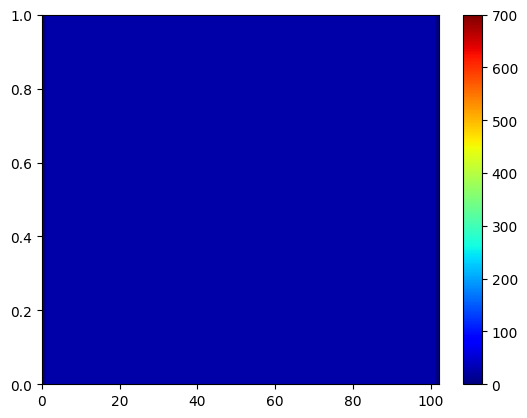

In [38]:
test.start()


In [1]:
def target1(L, xstep, total_time, tstep, bc, ic, c, plot_step):
    test = Heat1dSimu(L, xstep, total_time, tstep, bc, ic, c, plot_step, device='cuda', do_progress_bar=False)
    test.start(do_plot=False)

In [107]:
def target2(L, xstep, total_time, tstep, bc, ic, c, plot_step):
    if True: pass

In [2]:
%timeit -r 10 target1(L, xstep, total_time, tstep, bc, ic, c, plot_step)


NameError: name 'L' is not defined

In [108]:
%timeit -r 10 target2(L, xstep, total_time, tstep, bc, ic, c, plot_step)

58.5 ns ± 1.21 ns per loop (mean ± std. dev. of 10 runs, 10,000,000 loops each)


In [29]:
%load_ext line_profiler

In [36]:
%lprun -f target target(L, xstep, total_time, tstep, bc, ic, c, plot_step)


Timer unit: 1e-07 s

Total time: 5.9669 s
File: C:\Users\seer2\AppData\Local\Temp\ipykernel_18628\3438554829.py
Function: target at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def target(L, xstep, total_time, tstep, bc, ic, c, plot_step):
     2         1      26424.0  26424.0      0.0      test = Heat1dSimu(L, xstep, total_time, tstep, bc, ic, c, plot_step, 'cuda', False)
     3         1   59642526.0    6e+07    100.0      test.start(do_plot=False)

In [28]:
def subtract(a,b):
    return a-b

def torch_subtract(a,b):
    return torch.tensor(a)-torch.tensor(b)

In [30]:
%timeit subtract(2,1)
%timeit torch_subtract(2,1)

37.8 ns ± 0.663 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
5.16 μs ± 65.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
